# GPR-Accelerated NEB Tutorial

This tutorial demonstrates how to use `aenet-gpr` for **GPR-accelerated Nudged Elastic Band (NEB) calculations**, which accelerates the demanding NEB calculations for transition state search.

GPR-NEB references:
- [J. A. Garrido Torres, P. C. Jennings, M. H. Hansen, J. R. Boes, and T. Bligaard, “Low-Scaling Algorithm for Nudged Elastic Band Calculations Using a Surrogate Machine Learning Model”, *Phys. Rev. Lett.* 122, 156001 (2019).](https://doi.org/10.1103/PhysRevLett.122.156001)
- [O. Koistinen, F. B. Dagbjartsdóttir, V. Ásgeirsson, A. Vehtari, and H. Jónsson, "Nudged elastic band calculations accelerated with Gaussian process regression", *J. Chem. Phys.* 147, 152720 (2017)](https://doi.org/10.1063/1.4986787)

In this example, we use a simple **EMT potential** as the reference calculator. However, the same framework is fully compatible with any [ASE-compatible DFT calculators](https://wiki.fysik.dtu.dk/ase/ase/calculators/calculators.html).

Replacing the reference with a DFT calculator allows GPR-NEB to reproduce **transition states** on a DFT-level potential energy surface (PES), with **significantly fewer expensive DFT evaluations** than standard NEB.

# ===== Preparation =====

## Reference calculator: Effective Medium Theory (EMT)

In [24]:
try:
    import ase.io
    print("successfully imported ase")
except ImportError:
    !! pip install ase --user --upgrade
    print("completed installing ASE")

successfully imported ase


In [1]:
from ase.build import add_adsorbate, fcc100
from ase.calculators.emt import EMT
from ase.constraints import FixAtoms
from ase.optimize import QuasiNewton, BFGS, MDMin, FIRE

from IPython.display import Image
import copy
import numpy as np

In [2]:
# 2x2-Al(001) surface with 3 layers and an
# Au atom adsorbed in a hollow site:
slab = fcc100('Al', size=(2, 2, 3))
add_adsorbate(slab, 'Au', 1.7, 'hollow')
slab.center(axis=2, vacuum=4.0)

In [3]:
# Fix second and third layers:
mask = [atom.tag > 1 for atom in slab]
# print(mask)
slab.set_constraint(FixAtoms(mask=mask))

In [4]:
# Use EMT potential:
slab.calc = EMT()

In [5]:
# Initial state:
qn = BFGS(slab, trajectory='initial.traj')
qn.run(fmax=0.05)

      Step     Time          Energy          fmax
BFGS:    0 20:02:25        3.323870        0.246170
BFGS:    1 20:02:25        3.321365        0.203512
BFGS:    2 20:02:25        3.314740        0.020557


True

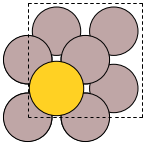

In [6]:
import ase


atoms = ase.io.read('initial.traj')
ase.io.write('initial.png', atoms)
Image("initial.png")

In [7]:
# Final state:
slab[-1].x += slab.get_cell()[0, 0] / 2
qn = BFGS(slab, trajectory='final.traj')
qn.run(fmax=0.05)

      Step     Time          Energy          fmax
BFGS:    0 20:02:26        3.320046        0.123468
BFGS:    1 20:02:26        3.319145        0.111073
BFGS:    2 20:02:26        3.315607        0.074162
BFGS:    3 20:02:26        3.315469        0.075507
BFGS:    4 20:02:26        3.314645        0.052638
BFGS:    5 20:02:26        3.314491        0.027698


True

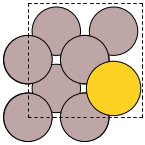

In [8]:
atoms = ase.io.read('final.traj')
ase.io.write('final.png', atoms)
Image("final.png")

# ===== Conventional NEB =====

In [9]:
from ase.calculators.emt import EMT
from ase.constraints import FixAtoms
from ase.io import read
from ase.mep import NEB

In [10]:
initial = read('initial.traj')
final = read('final.traj')

In [11]:
constraint = FixAtoms(mask=[atom.tag > 1 for atom in initial])

In [12]:
images = [initial]
for i in range(5):
    image = initial.copy()
    image.calc = EMT()
    image.set_constraint(constraint)
    images.append(image)

images.append(final)

In [13]:
neb = NEB(images)
neb.interpolate()
qn = BFGS(neb, trajectory='neb.traj')
qn.run(fmax=0.05)

      Step     Time          Energy          fmax
BFGS:    0 20:02:33        4.254555        3.670245
BFGS:    1 20:02:33        3.948627        2.244311
BFGS:    2 20:02:33        3.721026        0.460812
BFGS:    3 20:02:33        3.709871        0.220665
BFGS:    4 20:02:34        3.709278        0.252739
BFGS:    5 20:02:34        3.706857        0.272288
BFGS:    6 20:02:34        3.699467        0.212846
BFGS:    7 20:02:34        3.692513        0.248942
BFGS:    8 20:02:34        3.692122        0.220736
BFGS:    9 20:02:34        3.693252        0.170065
BFGS:   10 20:02:34        3.692612        0.156282
BFGS:   11 20:02:34        3.690770        0.082660
BFGS:   12 20:02:35        3.690148        0.072045
BFGS:   13 20:02:35        3.690308        0.070273
BFGS:   14 20:02:35        3.690294        0.089615
BFGS:   15 20:02:35        3.689736        0.081432
BFGS:   16 20:02:35        3.688950        0.060481
BFGS:   17 20:02:35        3.688746        0.033467


True

### Total reference calculations = NEB steps $\times$ number of moving images = 18 $\times$ 5 = 90

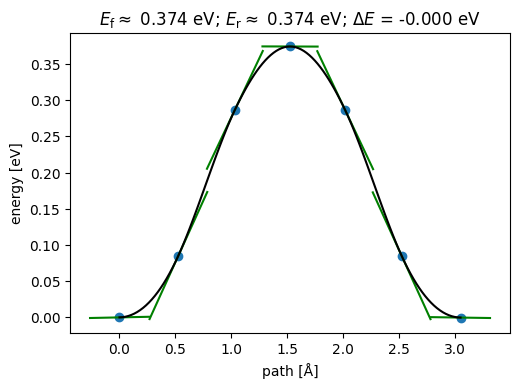

In [14]:
import matplotlib.pyplot as plt

from ase.io import read
from ase.mep import NEBTools

images = read('neb.traj@-7:')

nebtools = NEBTools(images)

# # Get the calculated barrier and the energy change of the reaction.
# Ef, dE = nebtools.get_barrier()

# # Get the barrier without any interpolation between highest images.
# Ef, dE = nebtools.get_barrier(fit=False)

# # Get the actual maximum force at this point in the simulation.
# max_force = nebtools.get_fmax()

# # Create a figure like that coming from ASE-GUI.
# fig = nebtools.plot_band()
# fig.savefig('diffusion-barrier.png')

# Create a figure with custom parameters.
fig = plt.figure(figsize=(5.5, 4.0))
ax = fig.add_axes((0.15, 0.15, 0.8, 0.75))
nebtools.plot_band(ax)
fig.savefig('diffusion-barrier.png')

# ===== aenet-GPR accelerated NEB =====

### Reference calculator: Effective Medium Theory (EMT)
### Surrogate calculator: aenet-gpr (GPR)

In [15]:
try:
    import torch
    print("successfully imported torch")
    print(torch.__version__)
except ImportError:
    !! pip install torch torchvision torchaudio --user --index-url https://download.pytorch.org/whl/cpu
    print("completed installing torch")

successfully imported torch
2.6.0+cu124


In [16]:
!! pip install aenet-gpr --user --upgrade
print("completed installing aenet-gpr")

! pip show aenet-gpr

completed installing aenet-gpr
Name: aenet-gpr
Version: 1.4.4
Summary: Atomistic simulation tools based on Gaussian Processes Regression
Home-page: https://github.com/atomisticnet/aenet-gpr
Author: In Won Yeu
Author-email: iy2185@columbia.edu
License: MPL-2.0
Location: /data/home/iy2185/.local/lib/python3.12/site-packages
Requires: ase, dscribe
Required-by: 


In [17]:
from aenet_gpr.tool.aidneb import AIDNEB

In [18]:
neb_F_max = 0.05  # cretirian of the force for the convergence.
neb_interpol = "idpp"  # "linear", "idpp", path to trajectory file
neb_n_images = 7  # total images including initial and final
use_mic = False

In [19]:
initial = read('initial.traj')
final = read('final.traj')

In [20]:
calc = EMT()

In [21]:
neb = AIDNEB(start=initial,
             end=final,
             interpolation=neb_interpol,
             n_images=neb_n_images,
             mic=use_mic,
             max_train_data=100,
             calculator=copy.deepcopy(calc),
             use_previous_observations=True)

In [22]:
neb.run(fmax=neb_F_max, unc_convergence=0.1, dt=0.05, ml_steps=200)

Training data size:  3
GPR model hyperparameters:  {'kerneltype': 'sqexp', 'scale': tensor(0.4000, dtype=torch.float64), 'weight': tensor(0.2439, dtype=torch.float64), 'noise': tensor(1.0000e-06, dtype=torch.float64), 'noisefactor': tensor(0.5000, dtype=torch.float64), 'prior': tensor(3.5489, dtype=torch.float64)}
       Step     Time          Energy          fmax
MDMin:    0 20:03:08        3.985101        2.657923
MDMin:    1 20:03:08        3.979616        2.662966
MDMin:    2 20:03:08        3.965763        2.671179
MDMin:    3 20:03:08        3.941999        2.661922
MDMin:    4 20:03:08        3.907399        2.602208
MDMin:    5 20:03:08        3.860984        2.452614
MDMin:    6 20:03:08        3.802161        2.181265
MDMin:    7 20:03:08        3.731584        1.825457
MDMin:    8 20:03:08        3.653911        1.364855
MDMin:    9 20:03:09        3.601630        0.953842
MDMin:   10 20:03:09        3.595835        0.648021
MDMin:   11 20:03:09        3.586829        0.3176

### Total reference calculations = Training data size $-$ initial and final images = 12

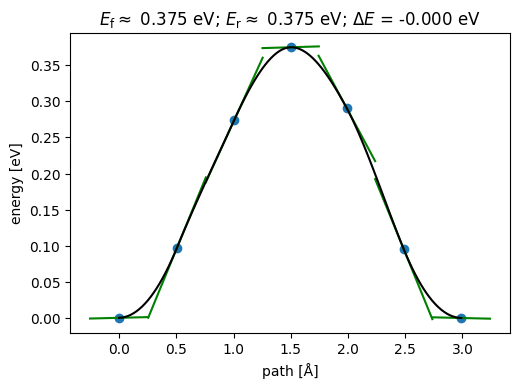

In [23]:
images = read('AIDNEB.traj@-7:')

nebtools = NEBTools(images)

# Create a figure with custom parameters.
fig = plt.figure(figsize=(5.5, 4.0))
ax = fig.add_axes((0.15, 0.15, 0.8, 0.75))
nebtools.plot_band(ax)
fig.savefig('diffusion-barrier.png')